# Evaluation

In [44]:
import os

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils

import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

import matplotlib.pyplot as plt

# Just for benchmarking
import time

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
# Root for images
dataroot = "train"

# Number of workers for dataloader
workers = 2

# Batch size
batch_size = 1

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [46]:
dataset = ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [47]:
def compare_real_gen(dataloader, model):
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the generated fake images
    noise = torch.randn(real_batch.shape[0], 100, 1, 1, device=device)
    fake_images = model.forward(noise)
    
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(fake_images, (1,2,0)))
    plt.show()

In [48]:
def create_images_mixed(dataloader, model):
    real = next(iter(dataloader))
    real = real[0][0]
    
    noise = torch.randn(batch_size, 100, 1, 1, device=device)
    fake = model.forward(noise)
    fake = fake[0]

    return real, fake

In [49]:
def plot_image(img, axes):
    real_image_data = img.permute(1, 2, 0).numpy()
    height, width, _ = real_image_data.shape
    axes.imshow(real_image_data)
    axes.set_xlim(0, width)
    axes.set_ylim(height, 0)
    
    return axes

In [50]:
def show_images_mixed(real, fake):
    fig, axes = plt.subplots(1,2)
    
    real_index = random.randint(0, 1)
    fake_index = 1 - real_index 
    
    plot_image(real, axes[real_index])
    
    fake = fake.detach()
    plot_image(fake, axes[fake_index])
    
    axes[0].set_title("0")
    axes[1].set_title("1")
    
    plt.show()
    x = input("Continue...")
    # Clear output
    return fake_index, x;

In [51]:
class Generator1(nn.Module):
    def __init__(self, ngpu):
        super(Generator1, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, ngf // 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),
            # state size. (ngf / 2) x 64 x 64
            nn.ConvTranspose2d( ngf // 2, nc, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [52]:
model = Generator1(ngpu).to(device)
model.load_state_dict(torch.load("netG1", map_location=torch.device('cpu')))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


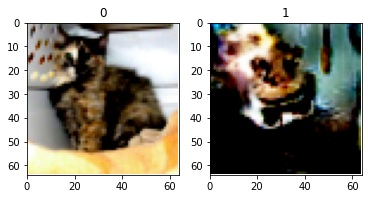

Continue...1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


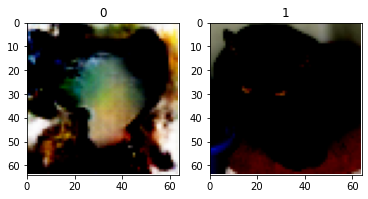

Continue...0
[True, True]
2


In [53]:
n_tests = 2
results = []

for i in range(n_tests): 
    real, fake = create_images_mixed(dataloader, model)
    results.append(show_images_mixed(real, fake))
    
correct_guesses = [x == int(y) for x,y in results]

print(correct_guesses)
print(sum(correct_guesses))


In [54]:
def LayerSize(input_size, kernel_size, stride, padding):
    return (input_size + 2 * padding - kernel_size) // stride + 1

In [56]:
class EvalNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.last_filter_dim = 32
        
        self.conv0 = nn.Conv2d(in_channels=3,  out_channels=8,                    kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels=8,  out_channels=16,                   kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=self.last_filter_dim, kernel_size=3)
        
        self.fc_size = LayerSize(input_size,   3, 1, 0) # Size after conv0
        self.fc_size = LayerSize(self.fc_size, 3, 1, 0) # Size after conv1
        self.fc_size = LayerSize(self.fc_size, 3, 1, 0) # Size after conv2
        self.fc_size = LayerSize(self.fc_size, 2, 2, 0) # Size after max pooling 0
        
        self.fc0 = nn.Linear(self.fc_size**2 * self.last_filter_dim, 500)
        self.fc1 = nn.Linear(500, 2)
        
        
    def forward(self, x):
        x = nn.BatchNorm2d(F.relu(self.conv0(x)))
        x = nn.BatchNorm2d(F.relu(self.conv1(x)))
        x = nn.BatchNorm2d(F.relu(self.conv2(x)))
        
        x = F.max_pool2d(x, kernel_size=2)
        
        x = torch.reshape(x, (-1, self.fc_size**2 * self.last_filter_dim))
        x = F.relu(self.fc0(x))
        
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [57]:
eval_real = EvalNet(64)
eval_fake = EvalNet(64)

In [61]:
def create_datasets(dataroot, batch_size=128):
    real_dataset = ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    # Create the dataloader
    real_dataloader = DataLoader(real_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)

    dataset_size = len(real_dataset)

    fake_labels = torch.randint(0,2,(dataset_size,)).to(device)
    noise = torch.randn(dataset_size, nz, 1, 1, device=device)

    # Generate fake image batch with G
    # TODO: Prepare for CGAN
    fake = model(noise) #, fake_labels)
    fake = fake.detach()

    fake_dataloader = DataLoader(fake, batch_size=batch_size,shuffle=True, num_workers=2)
    
    return real_dataset, real_dataloader, fake, fake_dataloader

In [ ]:
r_ds_train, r_dl_train, f_ds_train, f_dl_train = create_datasets("train")
r_ds_val, r_dl_val, f_ds_val, f_dl_val = create_datasets("val")
r_ds_test, r_dl_test, f_ds_test, f_dl_test = create_datasets("test")

In [62]:
def evaluate_model(val_data_loader, val_dataset, model, loss_fn):
    losses = []
    n_correct = 0
    with torch.no_grad():
        for b_x, b_y in val_data_loader:
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            
            pred = model(b_x)
            loss = loss_fn(pred, b_y)
            losses.append(loss.item())
            
            hard_preds = pred.argmax(dim=1)
            n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()
        val_accuracy = n_correct/len(val_dataset)
        val_avg_loss = sum(losses)/len(losses)    
    
    return val_accuracy, val_avg_loss

def train_model(model, 
                loss_fn, 
                optimizer, 
                epoch_num, 
                train_dataset, 
                train_data_loader, 
                val_dataset, 
                val_data_loader, 
                verboser=False,
                batch_print_num=10):
    train_losses = []
    train_accs   = []
    val_losses   = []
    val_accs     = []
    
    model.to(device)

    for epoch in range(epoch_num):
        losses = []
        n_correct = 0
        
        batch_counter = 0
        batch_n       = 0
        batch_correct = 0
        batch_loss    = []
        
        for b_x, b_y in train_data_loader:
            batch_counter += 1
            
            b_x = b_x.to(device)
            b_y = b_y.to(device)

            # Compute predictions and losses
            pred = model(b_x)
            loss = loss_fn(pred, b_y)
            losses.append(loss.item())
            batch_loss.append(loss.item())

            # Count number of correct predictions
            hard_preds = pred.argmax(dim=1)
            correct    = torch.sum(pred.argmax(dim=1) == b_y).item()
            n_correct += correct
            
            batch_n       += len(b_y)
            batch_correct += correct
            
            if verboser and batch_counter >= batch_print_num:
                print("Batch loss: {:.3f}\tBatch acc: {:.2f}".format(sum(batch_loss)/len(batch_loss), 
                                                                     batch_correct/batch_n))
                batch_counter = 0
                batch_n       = 0
                batch_correct = 0
                batch_loss    = []

            # Backpropagate
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_accuracy = n_correct/len(train_dataset)
        train_avg_loss = sum(losses)/len(losses)

        train_accs.append(train_accuracy)
        train_losses.append(train_avg_loss)

        # Compute accuracy and loss in the entire validation set
        val_accuracy, val_avg_loss = evaluate_model(val_data_loader, val_dataset, model, loss_fn)
        val_accs.append(val_accuracy)
        val_losses.append(val_avg_loss)

        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        display_str += '\tAccuracy: {:.2f} '
        display_str += '\tAccuracy (val): {:.2f}'
        print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))
        
    return model, train_accs, train_losses, val_accs, val_losses

In [ ]:
epoch_num = 15
lr        = 0.01

loss_fn     = nn.NLLLoss()
optimizer_r = optim.Adam(eval_real.parameters(), lr=lr)
optimizer_f = optim.Adam(eval_fake.parameters(), lr=lr)
    
_, r_ta, r_tl, r_va, r_vl = train_model(eval_real, 
                                        loss_fn, 
                                        optimizer_r, 
                                        epoch_num, 
                                        r_ds_train, 
                                        r_dl_train, 
                                        r_ds_val, 
                                        r_dl_val)
_, f_ta, f_tl, f_va, f_vl = train_model(eval_fake, 
                                        loss_fn, 
                                        optimizer_f, 
                                        epoch_num, 
                                        f_ds_train, 
                                        f_dl_train, 
                                        f_ds_val, 
                                        f_dl_val)

In [63]:
def plot_accs_losses(train_accs, train_losses, val_accs, val_losses, epoch_num):
    fig, axes = plt.subplots(1,2)

    fig.set_size_inches(20, 8)

    axes[0].plot(train_losses)
    axes[0].plot(val_losses)
    axes[0].legend(["Train", "Val"])
    axes[0].set_title("Losses")
    axes[0].set_xlabel("Epochs")
    axes[0].set_xticks(range(epoch_num))
    axes[0].set_xlim([0, epoch_num - 1])
    # axes[0].set_ylim([0, max(max(train_losses), max(val_losses))])

    axes[1].plot(train_accs)
    axes[1].plot(val_accs)
    axes[1].legend(["Train", "Val"])
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_xticks(range(epoch_num))
    axes[1].set_xlim([0, epoch_num - 1])
    axes[1].set_ylim([0, 1])

In [ ]:
plot_accs_losses(r_ta, r_tl, r_va, r_vl, epoch_num)
plot_accs_losses(f_ta, f_tl, f_va, f_vl, epoch_num)

In [ ]:
rm_rd_acc, rm_rd_loss = evaluate_model(r_dl_test, r_ds_test, eval_real, loss_fn)
rm_fd_acc, rm_fd_loss = evaluate_model(f_dl_test, f_ds_test, eval_real, loss_fn)
fm_rd_acc, fm_rd_loss = evaluate_model(r_dl_test, r_ds_test, eval_fake, loss_fn)
fm_fd_acc, fm_fd_loss = evaluate_model(f_dl_test, f_ds_test, eval_fake, loss_fn)

print("Real model + real data acc: {:.3f}\taverage loss: {:.3f}".format(rm_rd_acc, rm_rd_loss))
print("Real model + fake data acc: {:.3f}\taverage loss: {:.3f}".format(rm_fd_acc, rm_fd_loss))
print("Fake model + real data acc: {:.3f}\taverage loss: {:.3f}".format(fm_rd_acc, fm_rd_loss))
print("Fake model + fake data acc: {:.3f}\taverage loss: {:.3f}".format(fm_fd_acc, fm_fd_loss))